# Table of Contents:
* [Data Cleaning](#first-bullet)
* [Preprocessing](#second-bullet)
* [Modelling](#third-bullet)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Data Cleaning <a class="anchor" id="first-bullet"></a>

In [2]:
# loading in the data
companies = pd.read_csv('Data/companies.csv',sep=';')

In [3]:
# surveying
companies.head()

,Name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,permalink
0,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,05/01/2015,05/01/2015,/organization/-fame
1,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,04/09/2014,01/03/2014,14/10/2014,/organization/-qounter
2,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,30/01/2014,30/01/2014,/organization/-the-one-of-them-inc-
3,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,01/01/2007,19/03/2008,19/03/2008,/organization/0-6-com
4,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,01/01/2010,24/07/2014,24/07/2014,/organization/004-technologies


In [4]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63215 entries, 0 to 63214
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               63214 non-null  object
 1   homepage_url       59069 non-null  object
 2   category_list      63215 non-null  object
 3   funding_total_usd  63215 non-null  object
 4   status             63215 non-null  object
 5   country_code       57799 non-null  object
 6   state_code         56263 non-null  object
 7   region             56760 non-null  object
 8   city               56762 non-null  object
 9   funding_rounds     63215 non-null  int64 
 10  founded_at         49707 non-null  object
 11  first_funding_at   63192 non-null  object
 12  last_funding_at    63215 non-null  object
 13  permalink          63215 non-null  object
dtypes: int64(1), object(13)
memory usage: 6.8+ MB


In [5]:
companies.isna().sum()

Name                     1
homepage_url          4146
category_list            0
funding_total_usd        0
status                   0
country_code          5416
state_code            6952
region                6455
city                  6453
funding_rounds           0
founded_at           13508
first_funding_at        23
last_funding_at          0
permalink                0
dtype: int64

In [6]:
# just drop the one row with a missing name
companies.dropna(subset='Name', inplace=True)

In [7]:
# dropping URL column because I'm not sure how it would fit into a beginning model
companies.drop(columns='homepage_url', inplace=True)

In [8]:
# dropping region column because it seems redundant with city column
companies.drop(columns='region', inplace=True)

In [9]:
# dropping permalink column because it's a reference to crunchbase URLs which aren't relevant here
companies.drop(columns='permalink', inplace=True)

In [10]:
# dropping the rows where any of the location columns are null
companies.dropna(subset=['country_code', 'state_code', 'city'], inplace=True)

In [11]:
companies.head()

,Name,category_list,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,#fame,Media,10000000,operating,IND,16,Mumbai,1,NaN,05/01/2015,05/01/2015
1,:Qounter,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,Delaware City,2,04/09/2014,01/03/2014,14/10/2014
3,0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,1,01/01/2007,19/03/2008,19/03/2008
4,004 Technologies,Software,-,operating,USA,IL,Champaign,1,01/01/2010,24/07/2014,24/07/2014
6,Ondine Biomedical Inc.,Biotechnology,762851,operating,CAN,BC,Vancouver,2,01/01/1997,11/09/2009,21/12/2009


In [12]:
# resetting the index since dropping a lot of rows messed it up
companies.reset_index(drop=True, inplace=True)

In [13]:
companies.isna().sum()

Name                     0
category_list            0
funding_total_usd        0
status                   0
country_code             0
state_code               0
city                     0
funding_rounds           0
founded_at           10709
first_funding_at        22
last_funding_at          0
dtype: int64

##### Now the only null values left are with the 'founded_at' and 'first_funding_at' columns. I want to impute missing values for 'founded_at' from 'first_funding_at', and for 'first_funding_at' from 'last_funding_at'. Before doing that I will need to convert these date columns to datetime types since they are currently object types.

##### *Some of the code below is commented out because it returned errors and I wanted to be able to run all cells in the notebook automatically, but I left it there for reference.

In [14]:
#companies['founded_at'] = pd.to_datetime(companies['founded_at'])

In [15]:
# trying again, but with the format argument set to 'mixed'
#companies['founded_at'] = pd.to_datetime(companies['founded_at'], format='mixed')

In [16]:
# the error says there is a timestamp out of bounds, which company is this?
companies[companies['founded_at'] == '1636-09-08']

,Name,category_list,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
21034,Harvard University,Colleges|Education|Universities,90000000,operating,USA,MA,Cambridge,1,1636-09-08,06/01/2014,06/01/2014


In [17]:
# remove this row (since Harvard isn't exactly a startup anyway), and then retry converting to datetime
companies.drop(21034, inplace=True)

In [18]:
companies.reset_index(drop=True, inplace=True)

In [19]:
companies.loc[21034,:] #it's gone

Name                                                           Harvest
category_list        Billing|Enterprise Software|Project Management...
funding_total_usd                                                    -
status                                                       operating
country_code                                                       USA
state_code                                                          NY
city                                                          New York
funding_rounds                                                       1
founded_at                                                  01/04/2006
first_funding_at                                            01/01/2008
last_funding_at                                             01/01/2008
Name: 21034, dtype: object

In [20]:
# trying to convert to datetime again
companies['founded_at'] = pd.to_datetime(companies['founded_at'], format='mixed')

In [21]:
companies.info() # the type is changed now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55975 entries, 0 to 55974
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Name               55975 non-null  object        
 1   category_list      55975 non-null  object        
 2   funding_total_usd  55975 non-null  object        
 3   status             55975 non-null  object        
 4   country_code       55975 non-null  object        
 5   state_code         55975 non-null  object        
 6   city               55975 non-null  object        
 7   funding_rounds     55975 non-null  int64         
 8   founded_at         45266 non-null  datetime64[ns]
 9   first_funding_at   55953 non-null  object        
 10  last_funding_at    55975 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 4.7+ MB


In [22]:
companies.head() # nan changed to NaT

,Name,category_list,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,#fame,Media,10000000,operating,IND,16,Mumbai,1,NaT,05/01/2015,05/01/2015
1,:Qounter,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,Delaware City,2,2014-04-09,01/03/2014,14/10/2014
2,0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,1,2007-01-01,19/03/2008,19/03/2008
3,004 Technologies,Software,-,operating,USA,IL,Champaign,1,2010-01-01,24/07/2014,24/07/2014
4,Ondine Biomedical Inc.,Biotechnology,762851,operating,CAN,BC,Vancouver,2,1997-01-01,11/09/2009,21/12/2009


In [23]:
# converting first_funding_at
#companies['first_funding_at'] = pd.to_datetime(companies['first_funding_at'], format='mixed')

In [24]:
# another out of bounds timestamp, which one is this?
companies.loc[6304]

Name                                                  Blaze Bioscience
category_list        Biotechnology|Health Care|Health Care Informat...
funding_total_usd                                             32936998
status                                                       operating
country_code                                                       USA
state_code                                                          WA
city                                                           Seattle
funding_rounds                                                       5
founded_at                                         2010-01-01 00:00:00
first_funding_at                                            1532-06-26
last_funding_at                                             03/12/2013
Name: 6304, dtype: object

In [25]:
# this is clearly an erroneous date, but I don't want to drop the row. I'll change this value to nan
companies.at[6304, 'first_funding_at'] = np.nan

In [26]:
companies.loc[6304] # it's been changed

Name                                                  Blaze Bioscience
category_list        Biotechnology|Health Care|Health Care Informat...
funding_total_usd                                             32936998
status                                                       operating
country_code                                                       USA
state_code                                                          WA
city                                                           Seattle
funding_rounds                                                       5
founded_at                                         2010-01-01 00:00:00
first_funding_at                                                   NaN
last_funding_at                                             03/12/2013
Name: 6304, dtype: object

In [27]:
# try again
#companies['first_funding_at'] = pd.to_datetime(companies['first_funding_at'], format='mixed')

In [28]:
# another out of bounds timestamp
companies.loc[18833]

Name                                                         Gamewheel
category_list        Brand Marketing|Game|Mobile Advertising|Social...
funding_total_usd                                                    -
status                                                       operating
country_code                                                       DEU
state_code                                                          16
city                                                            Berlin
funding_rounds                                                       2
founded_at                                                         NaT
first_funding_at                                            1201-11-23
last_funding_at                                             03/12/2014
Name: 18833, dtype: object

In [29]:
# this also seems like a mistake, change it to nan as well
companies.at[18833, 'first_funding_at'] = np.nan

In [30]:
companies.loc[18833]

Name                                                         Gamewheel
category_list        Brand Marketing|Game|Mobile Advertising|Social...
funding_total_usd                                                    -
status                                                       operating
country_code                                                       DEU
state_code                                                          16
city                                                            Berlin
funding_rounds                                                       2
founded_at                                                         NaT
first_funding_at                                                   NaN
last_funding_at                                             03/12/2014
Name: 18833, dtype: object

In [31]:
# and again
#companies['first_funding_at'] = pd.to_datetime(companies['first_funding_at'], format='mixed')

In [32]:
# another out of bounds timestamp
companies.loc[31357]

Name                             Mousera
category_list              Biotechnology
funding_total_usd               29940004
status                         operating
country_code                         USA
state_code                            CA
city                           San Mateo
funding_rounds                         3
founded_at           2013-01-01 00:00:00
first_funding_at              1014-03-01
last_funding_at               09/06/2015
Name: 31357, dtype: object

In [33]:
# change this to nan as well
companies.at[31357, 'first_funding_at'] = np.nan

In [34]:
companies.loc[31357]

Name                             Mousera
category_list              Biotechnology
funding_total_usd               29940004
status                         operating
country_code                         USA
state_code                            CA
city                           San Mateo
funding_rounds                         3
founded_at           2013-01-01 00:00:00
first_funding_at                     NaN
last_funding_at               09/06/2015
Name: 31357, dtype: object

In [35]:
# and again
companies['first_funding_at'] = pd.to_datetime(companies['first_funding_at'], format='mixed')

In [36]:
companies.info() # type is now datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55975 entries, 0 to 55974
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Name               55975 non-null  object        
 1   category_list      55975 non-null  object        
 2   funding_total_usd  55975 non-null  object        
 3   status             55975 non-null  object        
 4   country_code       55975 non-null  object        
 5   state_code         55975 non-null  object        
 6   city               55975 non-null  object        
 7   funding_rounds     55975 non-null  int64         
 8   founded_at         45266 non-null  datetime64[ns]
 9   first_funding_at   55950 non-null  datetime64[ns]
 10  last_funding_at    55975 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 4.7+ MB


In [37]:
# converting last_funding_at now
companies['last_funding_at'] = pd.to_datetime(companies['last_funding_at'], format='mixed')

In [38]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55975 entries, 0 to 55974
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Name               55975 non-null  object        
 1   category_list      55975 non-null  object        
 2   funding_total_usd  55975 non-null  object        
 3   status             55975 non-null  object        
 4   country_code       55975 non-null  object        
 5   state_code         55975 non-null  object        
 6   city               55975 non-null  object        
 7   funding_rounds     55975 non-null  int64         
 8   founded_at         45266 non-null  datetime64[ns]
 9   first_funding_at   55950 non-null  datetime64[ns]
 10  last_funding_at    55975 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(7)
memory usage: 4.7+ MB


##### Now that all date columns are datetime types, I can impute 'first_funding_at' from 'last_funding_at' then 'founded_at' from 'first_funding_at'. I need to find the average difference in time between each set of the two columns and then use that to impute values.

In [39]:
companies.head()

,Name,category_list,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,#fame,Media,10000000,operating,IND,16,Mumbai,1,NaT,2015-05-01,2015-05-01
1,:Qounter,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,Delaware City,2,2014-04-09,2014-01-03,2014-10-14
2,0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,1,2007-01-01,2008-03-19,2008-03-19
3,004 Technologies,Software,-,operating,USA,IL,Champaign,1,2010-01-01,2014-07-24,2014-07-24
4,Ondine Biomedical Inc.,Biotechnology,762851,operating,CAN,BC,Vancouver,2,1997-01-01,2009-11-09,2009-12-21


In [40]:
# testing on index 0
companies['last_funding_at'][0] - companies['first_funding_at'][0] # returns Timedelta type

Timedelta('0 days 00:00:00')

In [41]:
# that works - now get the average timedelta between these columns
(companies['last_funding_at'] - companies['first_funding_at']).mean() # average timedelta is 390 days

Timedelta('390 days 00:04:56.493297588')

In [42]:
# saving to a variable
funding_timedelta = (companies['last_funding_at'] - companies['first_funding_at']).mean()

##### I also want to get the average timedelta between 'first_funding_at' and 'founded_at' before imputing values for 'first_funding_at' so that it's as accurate as possible.

In [43]:
(companies['first_funding_at'] - companies['founded_at']).mean()

Timedelta('1390 days 18:56:31.932810256')

In [44]:
founding_timedelta = (companies['first_funding_at'] - companies['founded_at']).mean()

In [45]:
# testing that this would work 
type(companies['founded_at'][0])
type(companies['founded_at'][0]) == pd._libs.tslibs.nattype.NaTType

True

In [46]:
# now impute values for 'first_funding_at' from 'last_funding_at'
for i in range(len(companies['first_funding_at'])):
    if type(companies.at[i, 'first_funding_at']) == pd._libs.tslibs.nattype.NaTType:
        companies.at[i, 'first_funding_at'] = companies.at[i, 'last_funding_at'] - funding_timedelta

In [47]:
# checking that 'first_funding_at' nulls are gone
companies.isna().sum()

Name                     0
category_list            0
funding_total_usd        0
status                   0
country_code             0
state_code               0
city                     0
funding_rounds           0
founded_at           10709
first_funding_at         0
last_funding_at          0
dtype: int64

In [48]:
# imputing the values for 'founded_at'
for i in range(len(companies['founded_at'])):
    if type(companies.at[i, 'founded_at']) == pd._libs.tslibs.nattype.NaTType:
        companies.at[i, 'founded_at'] = companies.at[i, 'first_funding_at'] - founding_timedelta

In [49]:
# all nulls are gone
companies.isna().sum()

Name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
dtype: int64

In [50]:
# check for duplicates
companies.duplicated().sum()

0

##### I've dealt with all null values but I can see that there's a row with a '-' value in the 'funding_total_usd' column and that the column is of type object not int or float. I need to remove the rows where this is the case because this column will form part of my y column in modelling, and then I need to change the type to int or float.

In [51]:
# first get the indeces for the rows I want to drop
dash_index = companies[companies['funding_total_usd'] == '-'].index

In [52]:
companies.drop(labels=dash_index, inplace=True)

In [53]:
companies.head()

,Name,category_list,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,#fame,Media,10000000,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01
1,:Qounter,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14
2,0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19
4,Ondine Biomedical Inc.,Biotechnology,762851,operating,CAN,BC,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21
5,H2O.ai,Analytics,33600000,operating,USA,CA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-03-01,2015-09-11


In [54]:
# reset index again
companies.reset_index(drop=True, inplace=True)

In [55]:
# change the type of the column now
companies['funding_total_usd'] = companies['funding_total_usd'].astype(float)

In [56]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46964 entries, 0 to 46963
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Name               46964 non-null  object        
 1   category_list      46964 non-null  object        
 2   funding_total_usd  46964 non-null  float64       
 3   status             46964 non-null  object        
 4   country_code       46964 non-null  object        
 5   state_code         46964 non-null  object        
 6   city               46964 non-null  object        
 7   funding_rounds     46964 non-null  int64         
 8   founded_at         46964 non-null  datetime64[ns]
 9   first_funding_at   46964 non-null  datetime64[ns]
 10  last_funding_at    46964 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1), object(6)
memory usage: 3.9+ MB


In [57]:
# moving on to the category_list column and cleaning that up
companies['category_list'].value_counts()

category_list
Software                                                                                                          3305
Biotechnology                                                                                                     3290
E-Commerce                                                                                                         929
Clean Technology                                                                                                   901
Mobile                                                                                                             887
                                                                                                                  ... 
Fashion|Search                                                                                                       1
Consumer Electronics|Hardware|Hardware + Software|Internet TV|Software                                               1
Business Development|Business Inte

##### The last column to clean is 'category_list' which is currently a string of industry categories all lumped together. I want to be able to see each category in a row individually, so I will create a new row that is a list of individual strings.

In [58]:
companies['categories'] = companies['category_list'].apply(lambda x: x.split('|'))

In [59]:
# dropping the category_list column since I've replaced it
companies.drop(columns='category_list', inplace=True)

In [60]:
companies.head()

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories
0,#fame,10000000.0,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01,[Media]
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw..."
2,0-6.com,2000000.0,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web]
3,Ondine Biomedical Inc.,762851.0,operating,CAN,BC,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology]
4,H2O.ai,33600000.0,operating,USA,CA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-03-01,2015-09-11,[Analytics]


# Preprocessing <a class="anchor" id="second-bullet"></a>

Now that the data has been cleaned I need to get it ready for modelling. I'll continue with the categories column to start. I want to create dummy columns for some number of the top categories.

In [61]:
companies.explode('categories') # I can use this to get the count of unique categories

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories
0,#fame,10000000.0,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01,Media
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,Application Platforms
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,Real Time
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,Social Network Media
2,0-6.com,2000000.0,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,Curated Web
...,...,...,...,...,...,...,...,...,...,...,...
46962,Zzzzapp Wireless ltd.,114304.0,operating,HRV,15,Split,4,2012-05-13 00:00:00.000000000,2011-01-11,2014-01-03,Web Development
46962,Zzzzapp Wireless ltd.,114304.0,operating,HRV,15,Split,4,2012-05-13 00:00:00.000000000,2011-01-11,2014-01-03,Wireless
46963,Ôasys,18192.0,operating,USA,CA,San Francisco,1,2014-01-01 00:00:00.000000000,2015-01-01,2015-01-01,Consumer Electronics
46963,Ôasys,18192.0,operating,USA,CA,San Francisco,1,2014-01-01 00:00:00.000000000,2015-01-01,2015-01-01,Internet of Things


In [62]:
companies.explode('categories')['categories'].value_counts()

categories
Software               6957
Mobile                 4228
Biotechnology          4111
E-Commerce             3017
Enterprise Software    2252
                       ... 
Made in Italy             1
Private Corrections       1
Hi Tech                   1
Hip Hop                   1
Micro-Enterprises         1
Name: count, Length: 850, dtype: int64

In [63]:
# What percentage of the data do 50 categories cover?
companies.explode('categories')['categories'].value_counts(normalize = True)[:50].sum()

0.559431128547784

##### 55% seems good enough for now, I'll dummy those 50 categories and lump the rest under 'Other'.

In [64]:
# getting a list of these top 50 categories
list(companies.explode('categories')['categories'].value_counts()[:50].index)

['Software',
 'Mobile',
 'Biotechnology',
 'E-Commerce',
 'Enterprise Software',
 'Curated Web',
 'Social Media',
 'Health Care',
 'Advertising',
 'SaaS',
 'Health and Wellness',
 'Games',
 'Analytics',
 'Education',
 'Internet',
 'Finance',
 'Technology',
 'Hardware + Software',
 'Clean Technology',
 'Apps',
 'Manufacturing',
 'Services',
 'Security',
 'Marketplaces',
 'Video',
 'Medical',
 'Big Data',
 'Cloud Computing',
 'Fashion',
 'Travel',
 'Search',
 'Information Technology',
 'Networking',
 'Sales and Marketing',
 'Music',
 'Semiconductors',
 'Social Network Media',
 'Real Estate',
 'Consulting',
 'Entertainment',
 'Startups',
 'News',
 'Media',
 'FinTech',
 'Web Hosting',
 'Retail',
 'Financial Services',
 'Sports',
 'Hospitality',
 'Messaging']

In [65]:
# creating a copy of the companies dataframe
df = companies.copy()

In [66]:
df.head()

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories
0,#fame,10000000.0,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01,[Media]
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw..."
2,0-6.com,2000000.0,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web]
3,Ondine Biomedical Inc.,762851.0,operating,CAN,BC,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology]
4,H2O.ai,33600000.0,operating,USA,CA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-03-01,2015-09-11,[Analytics]


In [67]:
# creating the dummy columns and populating them based on the categories column - 
# the Other column gets populated for any row that does not already had a top category column checked off
top_categories = list(df.explode('categories')['categories'].value_counts()[:50].index)
top_categories.sort()
for category in top_categories:
    df[category] = df.apply(lambda row: 1 if category in row['categories'] else 0, axis=1)
df['Other'] = df.apply(lambda row: 1 if len(np.setdiff1d(row['categories'], top_categories)) == len(row['categories']) else 0, axis=1)

In [68]:
pd.set_option('display.max_columns', 500)

In [69]:
df.head()

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other
0,#fame,10000000.0,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0-6.com,2000000.0,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ondine Biomedical Inc.,762851.0,operating,CAN,BC,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,H2O.ai,33600000.0,operating,USA,CA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-03-01,2015-09-11,[Analytics],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Now that I've dummied the categories column, I'll move on to the date columns. First I will change founded_at to the age of the company, using the latest date in the dataset as the present time since I'm not sure when this dataset was created. Then I'll change first_funding_at to the difference in time between it and the company age, which would represent the time to first funding from when the company started (will be negative in some instances). Lastly I'll change last_funding_at to the difference in time between it and the time of first funding.

In [70]:
# checking the max value in the founded_at column
df['founded_at'].max()

Timestamp('2104-01-01 00:00:00')

In [71]:
# that doesn't look right, which row is that
df.loc[df['founded_at']=='2104-01-01 00:00:00']

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other
37874,Soply,150000.0,operating,GBR,H9,London,1,2104-01-01,2013-01-07,2013-01-07,"[Creative Industries, Digital Media, Marketpla...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
#### I'm going to assume the date was inputted incorrectly and was intended to be 2014, so I'll change it to that
df.at[37874, 'founded_at'] = '2014-01-01 00:00:00'

In [73]:
# checking that it was changed
df.at[37874, 'founded_at']

Timestamp('2014-01-01 00:00:00')

In [74]:
# what's the max now?
df['founded_at'].max()

Timestamp('2015-12-23 00:00:00')

In [75]:
# that seems pretty normal, I'll just double check that it makes sense in context
df.loc[df['founded_at']=='2015-12-23 00:00:00']

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other
2093,American Development Group,5300000.0,operating,USA,NY,Brooklyn,1,2015-12-23,2015-09-01,2015-09-01,[Real Estate],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
# that looks good, I'll check the max in first_funding_at now
df['first_funding_at'].max()

Timestamp('2015-12-11 00:00:00')

In [77]:
df.loc[df['first_funding_at']=='2015-12-11 00:00:00']

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other
6314,Building Energy,6.300000e+05,operating,USA,OR,Portland,1,2012-02-19 05:03:28.067189744,2015-12-11,2015-12-11,"[Databases, Data Centers, Information Technology]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6513,C-Labs Corporation,2.700000e+06,operating,USA,WA,Redmond,1,2009-05-28 00:00:00.000000000,2015-12-11,2015-12-11,[Industrial Automation],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8852,Cola,1.300000e+06,operating,USA,CA,San Francisco,1,2015-01-01 00:00:00.000000000,2015-12-11,2015-12-11,[Apps],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16509,Globavir,1.500000e+05,operating,USA,CA,Los Altos,1,2014-01-01 00:00:00.000000000,2015-12-11,2015-12-11,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18545,Huuuge Games,4.000000e+06,operating,USA,CA,Palo Alto,1,2014-01-01 00:00:00.000000000,2015-12-11,2015-12-11,"[Entertainment, Games, Social Games]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18755,Iceye,2.800000e+06,operating,FIN,13,Espoo,1,2012-01-01 00:00:00.000000000,2015-12-11,2015-12-11,[Information Technology],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24037,MAKEUS,1.740000e+07,operating,JPN,18,China,1,2012-02-19 05:03:28.067189744,2015-12-11,2015-12-11,"[Advertising, Advertising Platforms, Services]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
33043,Qvivr,1.755027e+06,operating,USA,CA,Santa Clara,1,2014-01-01 00:00:00.000000000,2015-12-11,2015-12-11,"[Finance Technology, Internet of Things, Mobil...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
33492,Recardio,3.000000e+06,closed,USA,CA,San Francisco,1,2012-02-19 05:03:28.067189744,2015-12-11,2015-12-11,[Bio-Pharm],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
34143,Reusable Solutions Group,2.500000e+05,operating,USA,CA,Santa Cruz,1,2012-02-19 05:03:28.067189744,2015-12-11,2015-12-11,[Design],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [78]:
# check the max for last_funding_at
df['last_funding_at'].max()

Timestamp('2105-01-05 00:00:00')

In [79]:
# looks like another typo, I'll change it manually
df.loc[df['last_funding_at']=='2105-01-05 00:00:00']

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other
33290,Rasyonel R&D,220000.0,closed,TUR,35,Izmir,3,2013-03-20,2013-05-04,2105-01-05,"[Embedded Hardware and Software, Internet of T...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [80]:
df.at[33290, 'last_funding_at'] = '2015-01-05 00:00:00'

In [81]:
df.at[33290, 'last_funding_at']

Timestamp('2015-01-05 00:00:00')

In [82]:
# what's the max now?
df['last_funding_at'].max()

Timestamp('2015-12-12 00:00:00')

In [83]:
# ok so the max value from all the columns is 2015-12-23, I'll use that as the present date
present = df['founded_at'].max()

In [84]:
# checking that the minimum value of all founded dates subtracted from the present day is 0 (or higher)
(present - df['founded_at']).min()

Timedelta('0 days 00:00:00')

In [85]:
# checking that I can get just the days as ints from this new series of timedeltas
(present - df['founded_at']).dt.days

0        1626
1         623
2        3278
3        6930
4        1817
         ... 
46959    3278
46960     694
46961    2839
46962    1319
46963     721
Name: founded_at, Length: 46964, dtype: int64

In [86]:
# creating the new column with the integer value in days
df['company_age_days'] = (present - df['founded_at']).dt.days

In [87]:
df.head()

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days
0,#fame,10000000.0,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1626
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623
2,0-6.com,2000000.0,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278
3,Ondine Biomedical Inc.,762851.0,operating,CAN,BC,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930
4,H2O.ai,33600000.0,operating,USA,CA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-03-01,2015-09-11,[Analytics],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1817


In [88]:
df['company_age_years'] = df['company_age_days']/365

In [89]:
# creating the new column for the amount of time from founding to funding
df['founding_to_funding_days'] = (df['first_funding_at'] - df['founded_at']).dt.days

In [90]:
df.head()

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days
0,#fame,10000000.0,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1626,4.454795,1390
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.706849,-96
2,0-6.com,2000000.0,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.980822,443
3,Ondine Biomedical Inc.,762851.0,operating,CAN,BC,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.986301,4695
4,H2O.ai,33600000.0,operating,USA,CA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-03-01,2015-09-11,[Analytics],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1817,4.978082,790


In [91]:
# creating the new column for the amount of time from first funding to last
df['first_funding_to_last'] = (df['last_funding_at'] - df['first_funding_at']).dt.days

In [92]:
df.head()

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days,first_funding_to_last
0,#fame,10000000.0,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1626,4.454795,1390,0
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.706849,-96,284
2,0-6.com,2000000.0,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.980822,443,0
3,Ondine Biomedical Inc.,762851.0,operating,CAN,BC,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.986301,4695,42
4,H2O.ai,33600000.0,operating,USA,CA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-03-01,2015-09-11,[Analytics],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1817,4.978082,790,924


##### Now that I've dealt with the date columns I can move on to processing the location columns. I want to first see what the value counts/proportions are for the different values in those columns to determine which dummy columns to make. I will probably drop the state_code column and just use the city column since doing both seems redundant and if I'm using cities then the states can be inferred.

In [93]:
df['country_code'].value_counts()

country_code
USA    31017
GBR     2929
CAN     1553
IND     1151
CHN     1088
       ...  
HND        1
BWA        1
TGO        1
ALB        1
PRY        1
Name: count, Length: 116, dtype: int64

In [94]:
# I can see right away that USA accounts for the largest chunk for any one country by far, let's see the proportion
df['country_code'].value_counts(normalize=True)

country_code
USA    0.660442
GBR    0.062367
CAN    0.033068
IND    0.024508
CHN    0.023167
         ...   
HND    0.000021
BWA    0.000021
TGO    0.000021
ALB    0.000021
PRY    0.000021
Name: proportion, Length: 116, dtype: float64

In [95]:
# USA accounts for 66% of the data. Since this is such a high proportion I'll just create two dummy columns (or one) for this - USA vs. not USA
df['country_is_USA'] = np.where(df['country_code'] == 'USA', 1, 0)

In [96]:
df.head()

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days,first_funding_to_last,country_is_USA
0,#fame,10000000.0,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1626,4.454795,1390,0,0
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.706849,-96,284,1
2,0-6.com,2000000.0,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.980822,443,0,0
3,Ondine Biomedical Inc.,762851.0,operating,CAN,BC,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.986301,4695,42,0
4,H2O.ai,33600000.0,operating,USA,CA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-03-01,2015-09-11,[Analytics],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1817,4.978082,790,924,1


In [97]:
df['city'].value_counts()

city
San Francisco    2970
New York         2686
London           1571
Seattle           676
Austin            660
                 ... 
Celbridge           1
Flemington          1
Phoenixville        1
Fredrikstad         1
Split               1
Name: count, Length: 4229, dtype: int64

In [98]:
df['city'].value_counts(normalize=True)

city
San Francisco    0.063240
New York         0.057193
London           0.033451
Seattle          0.014394
Austin           0.014053
                   ...   
Celbridge        0.000021
Flemington       0.000021
Phoenixville     0.000021
Fredrikstad      0.000021
Split            0.000021
Name: proportion, Length: 4229, dtype: float64

In [99]:
# how many cities account for at least 1% each of the data?
(df['city'].value_counts(normalize=True) >= .01).sum()

14

In [100]:
list(df['city'].value_counts()[:14].index)

['San Francisco',
 'New York',
 'London',
 'Seattle',
 'Austin',
 'Palo Alto',
 'Cambridge',
 'Boston',
 'Los Angeles',
 'Chicago',
 'San Diego',
 'Mountain View',
 'Paris',
 'Beijing']

In [101]:
# I will create columns for these 14 cities
top_cities = list(df['city'].value_counts()[:14].index)
top_cities.sort()
for city in top_cities:
    df[city] = df.apply(lambda row: 1 if city == row['city'] else 0, axis=1)

In [102]:
df.head()

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days,first_funding_to_last,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle
0,#fame,10000000.0,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1626,4.454795,1390,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.706849,-96,284,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0-6.com,2000000.0,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.980822,443,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Ondine Biomedical Inc.,762851.0,operating,CAN,BC,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.986301,4695,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,H2O.ai,33600000.0,operating,USA,CA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-03-01,2015-09-11,[Analytics],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1817,4.978082,790,924,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


##### Now I need to create my y column, which will be based on the status and funding_total_usd columns. A company will be considered a success if it has IPO'd, been acquired, or is still operating and is above a certain threshold of funding total. A company will be considered a failure if it has closed or is still operating but has raised below a certain threshold. Now I need to determine what that threshold should be.

In [103]:
df['status'].value_counts()

status
operating    37503
acquired      4519
closed        3562
ipo           1380
Name: count, dtype: int64

In [104]:
# of the operating businesses, what is the average amount raised?
df[df['status']=='operating']['funding_total_usd'].mean() # 14,084,112.60

14083059.556949828

In [105]:
# what's the median?
df[df['status']=='operating']['funding_total_usd'].median() # 1,700,000.00

1700000.0

In [106]:
# how many companies raised at least 1.7 million?
(df[df['status']=='operating']['funding_total_usd'] >= 1700000.0).sum()

18775

##### If 1.7 million is my cutoff that would mean there would be 18,774 + 4,519 + 1,380 = 24,673 successful companies in the dataset, and 18,726 + 3,562 = 22,288 failed companies. This is 53% and 47% respectively, which is pretty close to even. I'll make \$1.7 million my threshold.

In [107]:
# creating a success column using the above stated conditions
df['successful'] = np.where((df['status'] == 'ipo') | (df['status'] == 'acquired') | ((df['status'] == 'operating') & (df['funding_total_usd'] >= 1700000.0)), 1, 0)

In [108]:
df.head()

,Name,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,categories,Advertising,Analytics,Apps,Big Data,Biotechnology,Clean Technology,Cloud Computing,Consulting,Curated Web,E-Commerce,Education,Enterprise Software,Entertainment,Fashion,FinTech,Finance,Financial Services,Games,Hardware + Software,Health Care,Health and Wellness,Hospitality,Information Technology,Internet,Manufacturing,Marketplaces,Media,Medical,Messaging,Mobile,Music,Networking,News,Real Estate,Retail,SaaS,Sales and Marketing,Search,Security,Semiconductors,Services,Social Media,Social Network Media,Software,Sports,Startups,Technology,Travel,Video,Web Hosting,Other,company_age_days,company_age_years,founding_to_funding_days,first_funding_to_last,country_is_USA,Austin,Beijing,Boston,Cambridge,Chicago,London,Los Angeles,Mountain View,New York,Palo Alto,Paris,San Diego,San Francisco,Seattle,successful
0,#fame,10000000.0,operating,IND,16,Mumbai,1,2011-07-10 05:03:28.067189744,2015-05-01,2015-05-01,[Media],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1626,4.454795,1390,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,:Qounter,700000.0,operating,USA,DE,Delaware City,2,2014-04-09 00:00:00.000000000,2014-01-03,2014-10-14,"[Application Platforms, Real Time, Social Netw...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,623,1.706849,-96,284,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0-6.com,2000000.0,operating,CHN,22,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,[Curated Web],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3278,8.980822,443,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Ondine Biomedical Inc.,762851.0,operating,CAN,BC,Vancouver,2,1997-01-01 00:00:00.000000000,2009-11-09,2009-12-21,[Biotechnology],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6930,18.986301,4695,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,H2O.ai,33600000.0,operating,USA,CA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-03-01,2015-09-11,[Analytics],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1817,4.978082,790,924,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


##### Now that everything has been thoroughly cleaned and preprocessed it'll be easier to create visualizations.

<Axes: xlabel='company_age_years', ylabel='Count'>

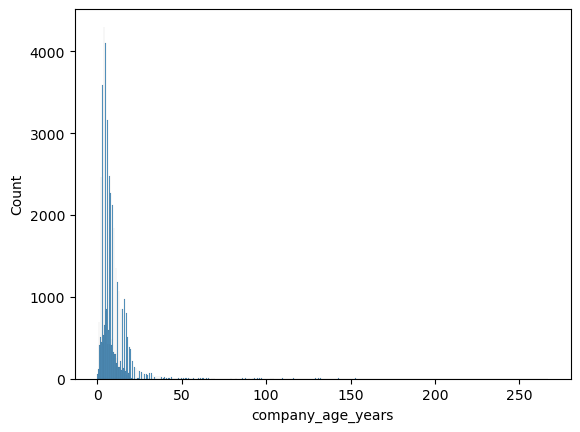

In [109]:
sns.histplot(df['company_age_years'])

In [110]:
# how many companies are there older than 50 years?
(df['company_age_years'] > 50).sum()

241

In [111]:
# drop these 240 companies
index = df[df['company_age_years'] > 50].index
df.drop(labels=index, inplace=True)

In [112]:
# checking
df['founded_at'].min()

Timestamp('1967-01-01 00:00:00')

[Text(0.5, 1.0, 'Histogram of Company Ages in Years')]

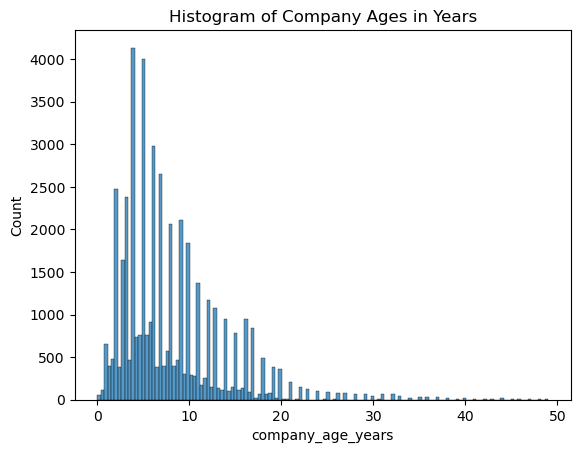

In [113]:
sns.histplot(df['company_age_years']).set(title='Histogram of Company Ages in Years')

[Text(0.5, 1.0, 'Histogram of Total Amounts Raised in Logscale')]

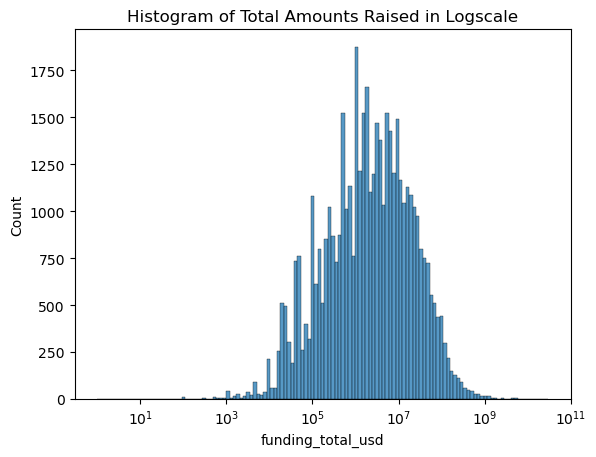

In [114]:
sns.histplot(df['funding_total_usd'], log_scale=True).set(title='Histogram of Total Amounts Raised in Logscale')

<Axes: title={'center': 'Top 10 Countries by Company Count'}, ylabel='country_code'>

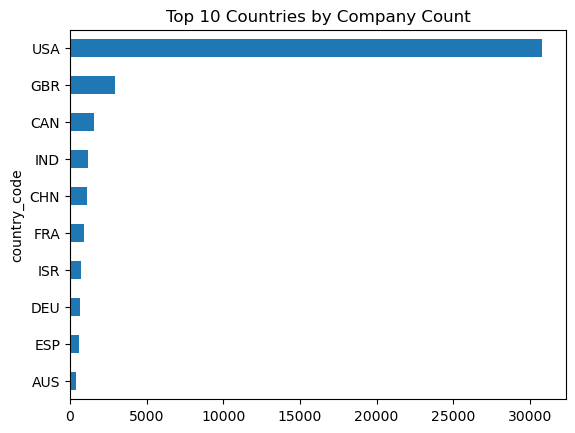

In [150]:
df['country_code'].value_counts()[:10].sort_values(ascending=True).plot(kind='barh', title='Top 10 Countries by Company Count')

In [156]:
df.groupby('status')['funding_total_usd'].mean()

status
acquired     2.831389e+07
closed       1.128668e+07
ipo          1.329649e+08
operating    1.395003e+07
Name: funding_total_usd, dtype: float64

<Axes: ylabel='status'>

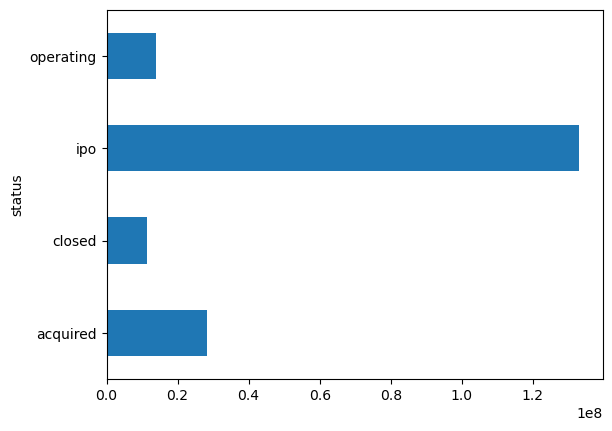

In [154]:
df.groupby('status')['funding_total_usd'].mean().plot(kind='barh')

In [157]:
df.columns

Index(['Name', 'funding_total_usd', 'status', 'country_code', 'state_code',
       'city', 'funding_rounds', 'founded_at', 'first_funding_at',
       'last_funding_at', 'categories', 'Advertising', 'Analytics', 'Apps',
       'Big Data', 'Biotechnology', 'Clean Technology', 'Cloud Computing',
       'Consulting', 'Curated Web', 'E-Commerce', 'Education',
       'Enterprise Software', 'Entertainment', 'Fashion', 'FinTech', 'Finance',
       'Financial Services', 'Games', 'Hardware + Software', 'Health Care',
       'Health and Wellness', 'Hospitality', 'Information Technology',
       'Internet', 'Manufacturing', 'Marketplaces', 'Media', 'Medical',
       'Messaging', 'Mobile', 'Music', 'Networking', 'News', 'Real Estate',
       'Retail', 'SaaS', 'Sales and Marketing', 'Search', 'Security',
       'Semiconductors', 'Services', 'Social Media', 'Social Network Media',
       'Software', 'Sports', 'Startups', 'Technology', 'Travel', 'Video',
       'Web Hosting', 'Other', 'company_age_day

In [169]:
catgroup = df.groupby('successful')[['Advertising', 'Analytics', 'Apps',
       'Big Data', 'Biotechnology', 'Clean Technology', 'Cloud Computing',
       'Consulting', 'Curated Web', 'E-Commerce', 'Education',
       'Enterprise Software', 'Entertainment', 'Fashion', 'FinTech', 'Finance',
       'Financial Services', 'Games', 'Hardware + Software', 'Health Care',
       'Health and Wellness', 'Hospitality', 'Information Technology',
       'Internet', 'Manufacturing', 'Marketplaces', 'Media', 'Medical',
       'Messaging', 'Mobile', 'Music', 'Networking', 'News', 'Real Estate',
       'Retail', 'SaaS', 'Sales and Marketing', 'Search', 'Security',
       'Semiconductors', 'Services', 'Social Media', 'Social Network Media',
       'Software', 'Sports', 'Startups', 'Technology', 'Travel', 'Video',
       'Web Hosting', 'Other']].sum().T#.plot(kind='barh', stacked=True)

In [172]:
catgroup['Total'] = catgroup[0] + catgroup[1]

<Axes: title={'center': 'Success vs. Failure for Top 10 Listed Categories'}>

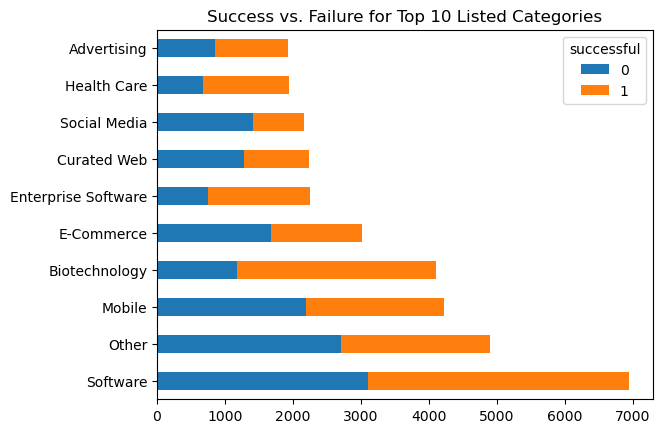

In [184]:
catgroup.sort_values('Total', ascending=False)[:10].drop(columns='Total').plot(kind='barh', stacked=True, title='Success vs. Failure for Top 10 Listed Categories')

In [185]:
temp = df.loc[df['city'].isin(list(df['city'].value_counts()[:14].index))]

<Axes: title={'center': 'Statuses for 14 Most Common Cities'}, ylabel='city'>

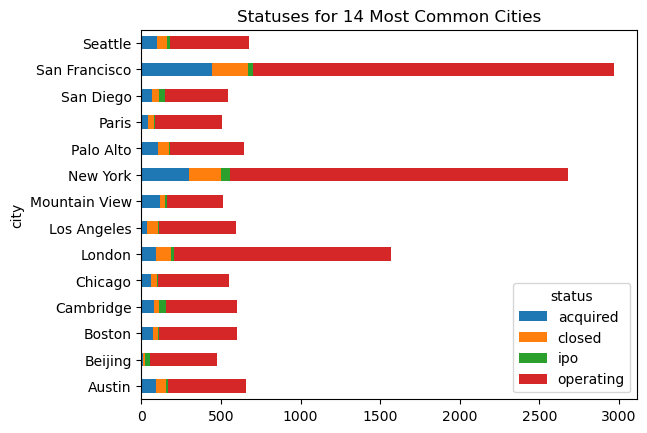

In [195]:
temp.groupby(['status', 'city'])['city'].count().unstack().T.plot(kind='barh', stacked=True, title='Statuses for 14 Most Common Cities')

In [196]:
# saving the name column in a separate variable
name = df['Name']

In [197]:
# now that I've created those three columns I can remove the original three datetime columns
df.drop(columns=['categories', 'founded_at', 'first_funding_at', 'last_funding_at', 'state_code', 'country_code', 'city', 'status', 'funding_total_usd', 'Name'], inplace=True)

# Modelling <a class="anchor" id="third-bullet"></a>

In [198]:
X = df.drop(columns='successful')
y = df['successful']

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


#Fit a logistic regression model
logreg_model = LogisticRegression(max_iter=10000)
logreg_model.fit(X_train, y_train)

#Score it
train_prediction = logreg_model.predict(X_train)
test_prediction = logreg_model.predict(X_test)
accuracy_train = accuracy_score(train_prediction, y_train)
accuracy_test = accuracy_score(test_prediction, y_test)

print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")


Score on training set: 0.7217024399192808
Score on test set: 0.7216950845402011


In [205]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, test_prediction)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Failure", "Predicted Success"],
    index=["True Failure", "True Success"]
)

display(cf_df)

,Predicted Failure,Predicted Success
True Failure,5170,1507
True Success,2394,4946


In [208]:
precision = precision_score(y_test, test_prediction)
recall = recall_score(y_test, test_prediction)
f1 = f1_score(y_test, test_prediction)
print(f'precision = {precision}, recall = {recall}, f1 = {f1}')

precision = 0.7664652099798543, recall = 0.673841961852861, f1 = 0.7171753788153412


In [214]:
coefs = pd.Series(np.exp(logreg_model.coef_)[0], X.columns).sort_values()

In [221]:
pd.DataFrame(coefs).T

,Social Media,Curated Web,Education,Social Network Media,Music,Marketplaces,Consulting,Sports,Apps,SaaS,Games,E-Commerce,Search,Hospitality,Hardware + Software,Health and Wellness,Travel,Messaging,Manufacturing,News,Startups,Sales and Marketing,Fashion,Services,London,Los Angeles,Video,Mobile,Entertainment,Real Estate,Internet,Networking,Media,company_age_years,founding_to_funding_days,company_age_days,first_funding_to_last,Seattle,Chicago,Software,Austin,Retail,Medical,Cloud Computing,San Diego,FinTech,Technology,Advertising,Information Technology,Web Hosting,Other,country_is_USA,Analytics,Big Data,Finance,Boston,Security,Paris,Palo Alto,Clean Technology,Semiconductors,Cambridge,Financial Services,Health Care,Mountain View,Biotechnology,funding_rounds,New York,Enterprise Software,Beijing,San Francisco
0,0.528315,0.622121,0.716455,0.720398,0.744668,0.756121,0.761174,0.77334,0.812094,0.816298,0.819963,0.821539,0.83042,0.832978,0.845731,0.853706,0.853988,0.859524,0.897464,0.902417,0.91156,0.927188,0.93166,0.937136,0.938125,0.942818,0.945276,0.946651,0.949687,0.956914,0.961469,0.984102,0.98563,1.000001,1.000102,1.00026,1.000876,1.008049,1.019016,1.019569,1.03755,1.038772,1.056899,1.064977,1.071059,1.082854,1.092844,1.096357,1.105212,1.106298,1.12989,1.139365,1.161947,1.161996,1.179584,1.180203,1.201281,1.208645,1.210372,1.221541,1.245363,1.247062,1.247533,1.258018,1.343933,1.366936,1.436675,1.513718,1.530984,1.571601,2.014371


In [215]:
coefs[:5]

Social Media            0.528315
Curated Web             0.622121
Education               0.716455
Social Network Media    0.720398
Music                   0.744668
dtype: float64

<Axes: title={'center': '5 Features With Lowest Correlation'}>

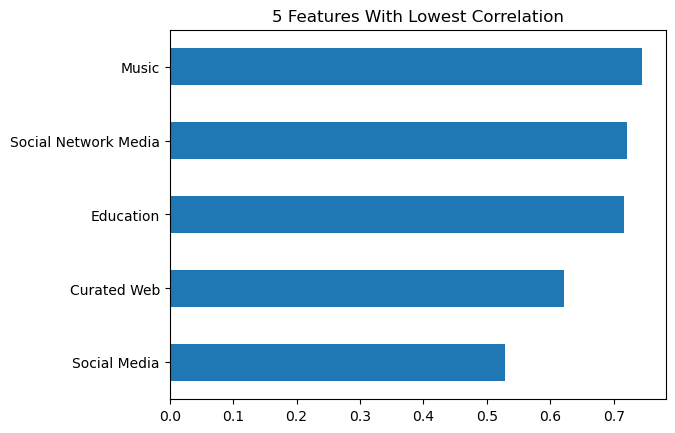

In [224]:
coefs[:5].plot(kind='barh', title='5 Features With Lowest Correlation')

In [216]:
coefs.sort_values(ascending=False)[:5]

San Francisco          2.014371
Beijing                1.571601
Enterprise Software    1.530984
New York               1.513718
funding_rounds         1.436675
dtype: float64

<Axes: title={'center': '5 Features With Highest Correlation'}>

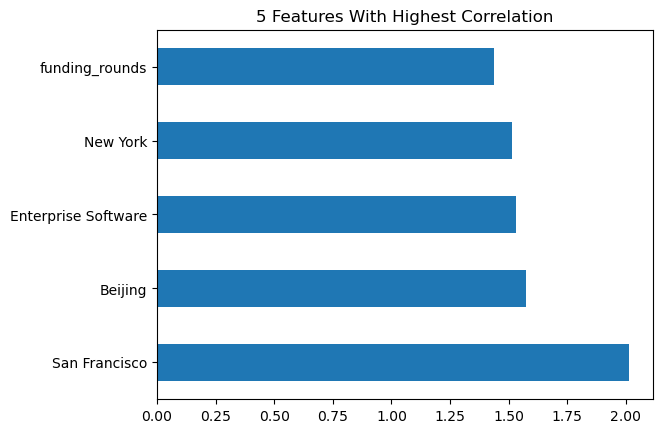

In [225]:
coefs.sort_values(ascending=False)[:5].plot(kind='barh', title='5 Features With Highest Correlation')